# Syncnet DEMO

https://github.com/voletiv/syncnet-in-keras/

1. Given a video (*.mp4), convert to proper input format to the Syncnet lip & audio models
2. Load the Syncnet lip and audio models
3. Calculate lip-video and audio embeddings using Syncnet
4. Calculate Euclidian distance between the lip and audio embeddings to check if video/audio are in sync

In [51]:
import cv2
# import dlib
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io.wavfile as wav
import skimage.color
import skimage.transform
import speechpy
import tqdm

In [75]:
import sys
sys.path.append('/home/voleti.vikram/syncnet-in-keras/')

# del sys.modules['syncnet_params']
# del sys.modules['syncnet_functions']
import syncnet_params
from syncnet_functions import load_pretrained_syncnet_model

In [4]:
import sys

sys.path.append('../')
import utils

# del sys.modules['morph_video_with_new_lip_landmarks']
sys.path.append('../andrew_ng/')
from morph_video_with_new_lip_landmarks import read_video_landmarks

# FUNCTIONS

## get_syncnet_lip_model_input

In [96]:
def interpolate_1D(y, rate_old, rate_new):
    x = np.arange(len(y))
    x_new = np.arange(0, len(y),
                      (len(y) - 1)/(len(y)/rate_old*rate_new - 1))
    x_new[-1] = x[-1]
    f = interpolate.interp1d(x, y)
    y_new = f(x_new)
    return y_new


def interpolate_landmarks_to_new_fps(landmarks_in_frames, video_fps_old, video_fps_new):
    x = np.arange(len(landmarks_in_frames))
    x_new = np.arange(0, len(landmarks_in_frames),
                      (len(landmarks_in_frames) - 1)/(len(landmarks_in_frames)/video_fps_old*video_fps_new - 1))
    x_new[-1] = x[-1]
    landmarks_in_frames_new = np.zeros((len(x_new), *landmarks_in_frames.shape[1:]))
    for lm in range(68):
        for d in range(2):
            y = landmarks_in_frames[:, lm, d]
            f = interpolate.interp1d(x, y)
            y_new = f(x_new)
            landmarks_in_frames_new[:, lm, d] = y_new
    return landmarks_in_frames_new


def convert_video_fps(video_file_name, required_fps=25, converted_video_file_name='/tmp/video.mp4'):
    cmd = "ffmpeg -i {} -r {} -y {}".format(video_file_name, str(int(required_fps)), converted_video_file_name)
    os.system(cmd)


def get_syncnet_lip_model_input(video_file_name):

    # EXAMPLE video_file_name = "/home/voleti.vikram/ANDREW_NG/videos/CV_02_C4W1L02_000006_to_000013/CV_02_C4W1L02_000006_to_000013_pauline_english_dub.mp4"

    # Video
    video_frames = imageio.get_reader(video_file_name)
    video_fps = video_frames.get_meta_data()['fps']
    if video_fps != syncnet_params.SYNCNET_VIDEO_FPS:
        convert_video_fps(video_file_name, required_fps=syncnet_params.SYNCNET_VIDEO_FPS, converted_video_file_name='/tmp/video.mp4')
        video_frames = imageio.get_reader('/tmp/video.mp4')

    # Landmarks
    landmarks_in_frames, frames_with_no_landmarks = read_video_landmarks(video_file_name=video_file_name, video_fps=video_fps)
    if video_fps != syncnet_params.SYNCNET_VIDEO_FPS:
        landmarks_in_frames = interpolate_landmarks_to_new_fps(landmarks_in_frames, video_fps, syncnet_params.SYNCNET_VIDEO_FPS)
        frames_with_no_landmarks = np.round(interpolate_1D(np.array(frames_with_no_landmarks),
                                                            video_fps, syncnet_params.SYNCNET_VIDEO_FPS)).astype(int)

    lip_model_input = []
    five_mouths = []
    consider_these_frames = []
    
    # Read frames from the video
    for frame, landmarks_in_frame, no_face_in_frame in zip(video_frames, landmarks_in_frames, frames_with_no_landmarks):

        if no_face_in_frame:
            five_mouths = []
            consider_these_frames.append(0)
        
        else:

            # Extract face from frame
            face_rect = utils.make_rect_shape_square([np.min(landmarks_in_frame[:, 0]), np.min(landmarks_in_frame[:, 1]),
                 np.max(landmarks_in_frame[:, 0]), np.max(landmarks_in_frame[:, 1])])

            # Extract mouth from frame
            mouth_rect = utils.make_rect_shape_square([np.min(landmarks_in_frame[48:68, 0]), np.min(landmarks_in_frame[48:68, 1]),
                          np.max(landmarks_in_frame[48:68, 0]), np.max(landmarks_in_frame[48:68, 1])])

            # Calculate scale to expand mouth rect to 0.6 times the face width
            scale = (face_rect[2] - face_rect[0])*0.6/(mouth_rect[2] - mouth_rect[0])

            # Expand mouth rect
            mouth_rect_exp = utils.expand_rect(mouth_rect, scale=scale, frame_shape=(frame.shape[0], frame.shape[1]))

            # Extract mouth from frame
            mouth = frame[mouth_rect_exp[1]:mouth_rect_exp[3], mouth_rect_exp[0]:mouth_rect_exp[2]]

            # Convert to grayscale, resize to syncnet input shape, subtract 110
            mouth = skimage.transform.resize(skimage.color.rgb2gray(mouth),
                                     (syncnet_params.MOUTH_H, syncnet_params.MOUTH_W)) * 255. - 110.

            if len(five_mouths) == syncnet_params.SYNCNET_VIDEO_CHANNELS:
                five_mouths = five_mouths[1:]

            five_mouths.append(mouth)
            
            if len(five_mouths) == syncnet_params.SYNCNET_VIDEO_CHANNELS:
                lip_model_input.append(np.stack(five_mouths, axis=-1))
                consider_these_frames.append(1)
            else:
                consider_these_frames.append(0)

    return np.array(lip_model_input), consider_these_frames

## get_syncnet_audio_model_input

In [113]:
def extract_syncnet_mfcc(wav_file, consider_these_frames=None, verbose=False):
    """To extract mfcc features of audio clips 0.2 seconds in length each,
    i.e. of 20 MFCC features in each clip (acc. to syncnet paper)
    Output mfcc_clips shape === (N, 12, 20, 1),
    where N = len(mfcc_features) // 20
    """

    rate, sig = wav.read(wav_file)
    if verbose:
        print("Sig length: {}, sample_rate: {}".format(len(sig), rate))

    try:
        mfcc_features = speechpy.feature.mfcc(sig, sampling_frequency=rate, frame_length=0.010, frame_stride=0.010)
    except IndexError:
        raise ValueError("ERROR: Index error occurred while extracting mfcc")

    if verbose:
        print("mfcc_features shape:", mfcc_features.shape)

    # Don't consider the first MFCC feature, only consider the next 12 (Checked in syncnet_demo.m)
    # Also, only consider syncnet_params.AUDIO_TIME_STEPS*number_of_audio_clips features
    mfcc_features = mfcc_features[:, 1:]

    # Take overlapping windows with stride length of 1 frame = 0.2/5 = .04 = 4 audio frames
    mfcc_features_more = []
    for i in range(0, len(mfcc_features)-syncnet_params.AUDIO_TIME_STEPS, 4):
        mfcc_features_more.append(mfcc_features[i:i+20])
    mfcc_features = np.array(mfcc_features_more)

    # Filter mfcc_features based on landmark detection in video
    if consider_these_frames is not None:
        mfcc_features_filtered = []
        for i in range(len(consider_these_frames)):
            if consider_these_frames[i]:
                mfcc_features_filtered.append(mfcc_features[i])
        mfcc_features = np.array(mfcc_features_filtered)

    # Reshape mfcc_features from (x, 12) to (x//20, 12, 20, 1)
    mfcc_features = np.expand_dims(np.transpose(mfcc_features, (0, 2, 1)), axis=-1)

    if verbose:
        print("Final mfcc_features shape:", mfcc_features.shape)

    return mfcc_features


def get_syncnet_audio_model_input(video, consider_these_frames=None):

    # Convert video's audio to .wav file
    audio_out = '/tmp/audio.wav'
    command = "ffmpeg -y -loglevel panic -i {} -acodec pcm_s16le -ac 1 -ar 16000 {}".format(video, audio_out)
    os.system(command)

    # Extract proper input to syncnet_audio_model
    return extract_syncnet_mfcc(audio_out, consider_these_frames)

# 1. Given a video, convert to proper inputs to the Syncnet lip & audio models

In [88]:
video_to_test = "/home/voleti.vikram/ANDREW_NG/videos/CV_02_C4W1L02_000006_to_000013/CV_02_C4W1L02_000006_to_000013_pauline_english_dub.mp4"

### Convert video to Syncnet lip model input

In [97]:
lip_input, consider_these_frames = get_syncnet_lip_model_input(video_to_test)
print(lip_input.shape)

/users/voleti.vikram/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(162, 112, 112, 5)


### Convert video's audio to Syncnet audio model input

In [100]:
audio_input = get_syncnet_audio_model_input(video_to_test, consider_these_frames)
print(audio_input.shape)

(154, 12, 20, 1)


# 2. Load the Syncnet lip and audio models

In [102]:
version = 'v4'
mode = 'both'
syncnet_audio_model, syncnet_lip_model = load_pretrained_syncnet_model(version=version, mode=mode, verbose=False)

In [ ]:
# print(syncnet_audio_model.summary())

In [ ]:
# print(syncnet_lip_model.summary())

# 3. Calculate lip-video and audio embeddings using Syncnet

In [103]:
lip_embeddings = syncnet_lip_model.predict(lip_input)
print(lip_embeddings.shape)

(162, 128)


In [104]:
audio_embeddings = syncnet_audio_model.predict(audio_input)
print(audio_embeddings.shape)

(154, 128)


# 4. Calculate Euclidian distance between the lip and audio embeddings to check if video/audio are in sync

1. Pass the audio frame through the audio model to get its encoding (a 128-dimensional feature), pass the video frame through the lip model to get its encoding (a 128-dimensional features)

2. Check the euclidean distance between the audio encoding and the video encoding.

3. If the distance is greater than a threshold, then it is said that audio frame and that video frame are not in sync.

In [105]:
def euclidian_distance(np_data_1, np_data_2): 
    dist = np.sqrt( np.sum(np.square(np_data_1 - np_data_2), axis=-1) )
    return dist

In [106]:
number_of_samples = min(len(audio_embeddings), len(lip_embeddings))
distances = euclidian_distance(audio_embeddings[:number_of_samples], lip_embeddings[:number_of_samples])
print(distances)

[15.356259  14.741577  12.049586  11.563585  11.02644   10.556869
 10.531931  10.381841  11.440622  11.78096   11.817664  11.621676
 12.14562   12.589324  11.39152   11.206246  11.807522  12.712593
 12.798426  12.073975  11.629025  10.503228   9.044234   9.025579
  9.391743  10.613449  10.838661  11.094656  10.102023  11.553209
 10.612234  10.067835   8.102941   9.613855  11.55113   11.585184
 10.662365   9.652776  10.207064  10.16248   12.366514  12.827551
 13.461684  12.872354  12.267968  11.475857  11.592371  11.316454
 11.059078  11.751394  13.126397  12.47847   10.669464  10.296844
 10.525674  10.946318  10.644928  11.292178  12.860302  12.476631
 11.872382  12.654462  10.816132  10.370273  10.169142   9.089098
  9.022907   9.244683   9.900251   9.909212  11.734487  11.638993
 11.2878895 10.140364  10.200824   9.395961  10.175902  11.16187
 11.672827  10.1642685  9.973168  10.46129   12.116207  13.006973
 13.284137  12.308081  11.98013   11.854091  10.314296   9.338659
  7.8301773

In [107]:
np.mean(distances)

11.242237

# FULL EXAMPLE

In [108]:
# # LOAD SYNCNET MODEL
# version = 'v4'
# mode = 'both'
# syncnet_audio_model, syncnet_lip_model = load_pretrained_syncnet_model(version=version, mode=mode, verbose=False)

# VIDEO
video_to_test = "/home/voleti.vikram/ANDREW_NG/videos/CV_02_C4W1L02_000006_to_000013/CV_02_C4W1L02_000006_to_000013_pauline_english_dp.mp4"

# LIP EMBEDDINGS
lip_input, consider_these_frames = get_syncnet_lip_model_input(video_to_test)
lip_embeddings = syncnet_lip_model.predict(lip_input)

# AUDIO EMBEDDINGS
audio_input = get_syncnet_audio_model_input(video_to_test, consider_these_frames)
audio_embeddings = syncnet_audio_model.predict(audio_input)

# DISTANCES
number_of_samples = min(len(audio_embeddings), len(lip_embeddings))
distances = euclidian_distance(audio_embeddings[:number_of_samples], lip_embeddings[:number_of_samples])
d = np.mean(distances)
print(d)

/users/voleti.vikram/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


11.719736


# CONSOLIDATED FUNCTION

In [111]:
def find_mean_dist_bw_audio_and_video(video, syncnet_lip_model=None, syncnet_audio_model=None,
                                      version='v4', mode='both'):
    # LOAD SYNCNET MODEL
    if syncnet_audio_model is None and syncnet_lip_model is None:
        syncnet_audio_model, syncnet_lip_model = load_pretrained_syncnet_model(version=version, mode=mode, verbose=False)
    elif syncnet_lip_model is None:
        syncnet_lip_model = load_pretrained_syncnet_model(version=version, mode='lip', verbose=False)
    elif syncnet_audio_model is None:
        syncnet_audio_model = load_pretrained_syncnet_model(version=version, mode='audio', verbose=False)

    # VIDEO
    # video_to_test = "/home/voleti.vikram/ANDREW_NG/videos/CV_02_C4W1L02_000006_to_000013/CV_02_C4W1L02_000006_to_000013_pauline_english_dp.mp4"

    # LIP EMBEDDINGS
    lip_input, consider_these_frames = get_syncnet_lip_model_input(video)
    lip_embeddings = syncnet_lip_model.predict(lip_input)

    # AUDIO EMBEDDINGS
    audio_input = get_syncnet_audio_model_input(video, consider_these_frames)
    audio_embeddings = syncnet_audio_model.predict(audio_input)

    # DISTANCES
    number_of_samples = min(len(audio_embeddings), len(lip_embeddings))
    distances = euclidian_distance(audio_embeddings[:number_of_samples], lip_embeddings[:number_of_samples])
    d = np.mean(distances)
    print(d)

In [114]:
video = "/home/voleti.vikram/ANDREW_NG/videos/CV_02_C4W1L02_000006_to_000013/CV_02_C4W1L02_000006_to_000013_ma_00_dub.mp4"
find_mean_dist_bw_audio_and_video(video, syncnet_lip_model, syncnet_audio_model)

/users/voleti.vikram/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


11.704552


In [115]:
video = "/home/voleti.vikram/ANDREW_NG/videos/CV_02_C4W1L02_000006_to_000013/CV_02_C4W1L02_000006_to_000013_ma_00_dp.mp4"
find_mean_dist_bw_audio_and_video(video, syncnet_lip_model, syncnet_audio_model)

/users/voleti.vikram/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


12.109784


# SCRATCHPAD

In [5]:
video_file_name = "/home/voleti.vikram/ANDREW_NG/videos/CV_02_C4W1L02_000006_to_000013/CV_02_C4W1L02_000006_to_000013_pauline_english_dub.mp4"

In [6]:
video_frames = imageio.get_reader(video_file_name)
video_fps = video_frames.get_meta_data()['fps']
print(len(video_frames), video_fps)

225 30.0


In [9]:
7*30

210

In [7]:
landmarks_in_frames, frames_with_no_landmarks = read_video_landmarks(video_file_name=video_file_name, video_fps=video_fps, verbose=True)
len(landmarks_in_frames), len(frames_with_no_landmarks)

read_video_landmarks: read_from_landmarks_file for /home/voleti.vikram/ANDREW_NG/videos/CV_02_C4W1L02_000006_to_000013/CV_02_C4W1L02_000006_to_000013_pauline_english_dub.mp4
read_video_landmarks: Found landmarks file /shared/fusor/home/voleti.vikram/ANDREW_NG/landmarks_in_frames_person/CV_02.C4W1L02_Edge_Detection_Examples_landmarks_in_frames_andrew_ng.txt
000006_to_00001 0 0 6 180
start_frame_number 180
required_number 211
frame_number 180 ; landmarks_frame_number 192
frame_number 181 ; landmarks_frame_number 192
frame_number 182 ; landmarks_frame_number 192
frame_number 183 ; landmarks_frame_number 192
frame_number 184 ; landmarks_frame_number 192
frame_number 185 ; landmarks_frame_number 192
frame_number 186 ; landmarks_frame_number 192
frame_number 187 ; landmarks_frame_number 192
frame_number 188 ; landmarks_frame_number 192
frame_number 189 ; landmarks_frame_number 192
frame_number 190 ; landmarks_frame_number 192
frame_number 191 ; landmarks_frame_number 192
frame_number 192 ; l

(211, 211)

In [12]:
convert_video_fps(video_file_name, required_fps=syncnet_params.SYNCNET_VIDEO_FPS, converted_video_file_name='/tmp/video.mp4')
video_frames = imageio.get_reader('/tmp/video.mp4')
print(len(video_frames), video_frames.get_meta_data()['fps'])

189 25.0


In [13]:
from scipy import interpolate

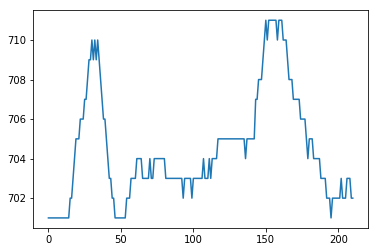

In [14]:
x = np.arange(len(landmarks_in_frames))
y = landmarks_in_frames[:, 0, 0]
plt.plot(x, y)

In [26]:
f = interpolate.interp1d(x, y)

In [46]:
a = np.arange(0, 30, (30)/25)
print(a, len(a))

[ 0.   1.2  2.4  3.6  4.8  6.   7.2  8.4  9.6 10.8 12.  13.2 14.4 15.6
 16.8 18.  19.2 20.4 21.6 22.8 24.  25.2 26.4 27.6 28.8] 25


In [60]:
# Change fps from 30 to 25
x_new = np.arange(0, len(landmarks_in_frames),
                  (len(landmarks_in_frames) - 1)/(len(landmarks_in_frames)/video_fps*syncnet_params.SYNCNET_VIDEO_FPS - 1))
x_new[-1] = x[-1]
# print(x)
print(x_new)
len(x_new)

[  0.           1.20114395   2.40228789   3.60343184   4.80457579
   6.00571973   7.20686368   8.40800763   9.60915157  10.81029552
  12.01143947  13.21258341  14.41372736  15.61487131  16.81601525
  18.0171592   19.21830315  20.41944709  21.62059104  22.82173499
  24.02287893  25.22402288  26.42516683  27.62631077  28.82745472
  30.02859867  31.22974261  32.43088656  33.63203051  34.83317445
  36.0343184   37.23546235  38.43660629  39.63775024  40.83889418
  42.04003813  43.24118208  44.44232602  45.64346997  46.84461392
  48.04575786  49.24690181  50.44804576  51.6491897   52.85033365
  54.0514776   55.25262154  56.45376549  57.65490944  58.85605338
  60.05719733  61.25834128  62.45948522  63.66062917  64.86177312
  66.06291706  67.26406101  68.46520496  69.6663489   70.86749285
  72.0686368   73.26978074  74.47092469  75.67206864  76.87321258
  78.07435653  79.27550048  80.47664442  81.67778837  82.87893232
  84.08007626  85.28122021  86.48236416  87.6835081   88.88465205
  90.08579

176

In [48]:
y_new = f(x_new)

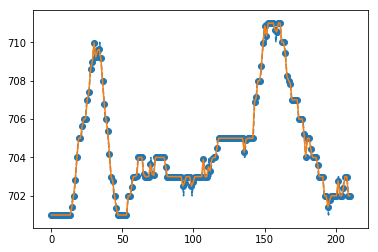

In [49]:
plt.plot(x, y, '--', x_new, y_new, '-')
plt.scatter(x_new, y_new)

N-dimensional data

In [58]:
def interpolate_landmarks_to_new_fps(landmarks_in_frames, video_fps_old, video_fps_new):
    x = np.arange(len(landmarks_in_frames))
    x_new = np.arange(0, len(landmarks_in_frames),
                      (len(landmarks_in_frames) - 1)/(len(landmarks_in_frames)/video_fps_old*video_fps_new - 1))
    x_new[-1] = x[-1]
    landmarks_in_frames_new = np.zeros((len(x_new), *landmarks_in_frames.shape[1:]))
    for lm in range(68):
        for d in range(2):
            y = landmarks_in_frames[:, lm, d]
            f = interpolate.interp1d(x, y)
            y_new = f(x_new)
            landmarks_in_frames_new[:, lm, d] = y_new
    return landmarks_in_frames_new

In [59]:
landmarks_in_frames_new = interpolate_landmarks_to_new_fps(landmarks_in_frames, video_fps, syncnet_params.SYNCNET_VIDEO_FPS)

In [117]:
for frame, landmarks_in_frame, no_face_in_frame in zip(video_frames, landmarks_in_frames, frames_with_no_landmarks):
    if not no_face_in_frame:
        break

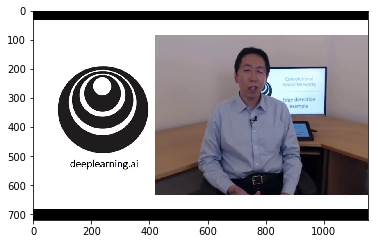

In [21]:
plt.imshow(frame)

In [36]:
face_rect = utils.make_rect_shape_square([np.min(landmarks_in_frame[:, 0]), np.min(landmarks_in_frame[:, 1]),
             np.max(landmarks_in_frame[:, 0]), np.max(landmarks_in_frame[:, 1])])

mouth_rect = utils.make_rect_shape_square([np.min(landmarks_in_frame[48:68, 0]), np.min(landmarks_in_frame[48:68, 1]),
              np.max(landmarks_in_frame[48:68, 0]), np.max(landmarks_in_frame[48:68, 1])])

scale = (face_rect[2] - face_rect[0])*0.6/(mouth_rect[2] - mouth_rect[0])

mouth_rect_exp = utils.expand_rect(mouth_rect, scale=scale, frame_shape=(frame.shape[0], frame.shape[1]))
print(face_rect)
print(mouth_rect)
print(mouth_rect_exp)

[692, 184.0, 809.0, 301.0]
[738.0, 252, 770.0, 284.0]
[719, 233, 789, 303]


/users/voleti.vikram/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


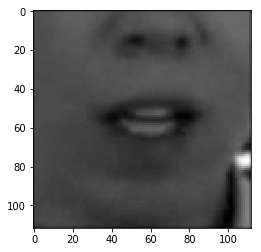

In [55]:
mouth = frame[mouth_rect_exp[1]:mouth_rect_exp[3], mouth_rect_exp[0]:mouth_rect_exp[2]]
mouth = skimage.transform.resize(skimage.color.rgb2gray(mouth),
                                 (syncnet_params.MOUTH_H, syncnet_params.MOUTH_W)) * 255.
plt.imshow(mouth, cmap='gray')

In [56]:
mouth.max()

239.06948281249996

[692, 184.0, 809.0, 301.0]
[663, 155, 838, 330]


/users/voleti.vikram/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


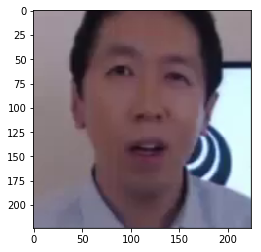

In [129]:
face_rect = utils.make_rect_shape_square([np.min(landmarks_in_frame[:, 0]), np.min(landmarks_in_frame[:, 1]),
             np.max(landmarks_in_frame[:, 0]), np.max(landmarks_in_frame[:, 1])])

# mouth_rect = utils.make_rect_shape_square([np.min(landmarks_in_frame[48:68, 0]), np.min(landmarks_in_frame[48:68, 1]),
#               np.max(landmarks_in_frame[48:68, 0]), np.max(landmarks_in_frame[48:68, 1])])

face_rect_exp = utils.expand_rect(face_rect, scale=1.5, frame_shape=(frame.shape[0], frame.shape[1]))

face = frame[face_rect_exp[1]:face_rect_exp[3], face_rect_exp[0]:face_rect_exp[2]]
face = np.round(skimage.transform.resize(face, (224, 224)) * 255.).astype('uint8')
print(face_rect)
print(face_rect_exp)
plt.imshow(face)

In [130]:
face.max()

255

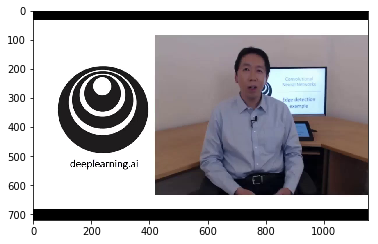

In [122]:
plt.imshow(frame)

In [131]:
def convert_video_fps(video_file_name, required_fps=25, converted_video_file_name='/tmp/video.mp4'):
    cmd = "ffmpeg -i {} -r {} -y {}".format(video_file_name, str(int(required_fps)), converted_video_file_name)
    os.system(cmd)


def make_video_for_syncnet_pytorch(video_file_name):

    # Video
    video_frames = imageio.get_reader(video_file_name)
    video_fps = video_frames.get_meta_data()['fps']

    # Landmarks
    landmarks_in_frames, frames_with_no_landmarks = read_video_landmarks(video_file_name=video_file_name, video_fps=video_fps)

    faces = []

    # Make video of faces for syncnet
    for frame, landmarks_in_frame, no_face_in_frame in tqdm.tqdm(zip(video_frames, landmarks_in_frames, frames_with_no_landmarks),
                                                                 total=len(video_frames)):

        # face_rect
        face_rect = utils.make_rect_shape_square([np.min(landmarks_in_frame[:, 0]), np.min(landmarks_in_frame[:, 1]),
                                                  np.max(landmarks_in_frame[:, 0]), np.max(landmarks_in_frame[:, 1])])
        # Expand face_rect
        face_rect_exp = utils.expand_rect(face_rect, scale=1.5, frame_shape=(frame.shape[0], frame.shape[1]))

        # Extract face
        face = frame[face_rect_exp[1]:face_rect_exp[3], face_rect_exp[0]:face_rect_exp[2]]
        face = np.round(skimage.transform.resize(face, (224, 224)) * 255.).astype('uint8')
        faces.append(face)
    
    # Convert video's audio to .wav file
    audio_out = '/tmp/audio.wav'
    command = "ffmpeg -y -loglevel error -i {} -acodec pcm_s16le -ac 1 -ar 16000 {}".format(video_file_name, audio_out)
    os.system(command)

    # Save video
    output_file_name = os.path.splitext(video_file_name)[0] + '_faces' + os.path.splitext(video_file_name)[-1]
    print("Saving faces video as", output_file_name)
    utils.save_new_video_frames_with_target_audio_as_mp4(faces, video_fps, audio_out,
                                                         output_file_name=output_file_name, verbose=verbose)

    if video_fps != syncnet_params.SYNCNET_VIDEO_FPS:
        print("Converting fps from", video_fps, "to", syncnet_params.SYNCNET_VIDEO_FPS)
        convert_video_fps(output_file_name, required_fps=syncnet_params.SYNCNET_VIDEO_FPS, converted_video_file_name=output_file_name)
